In [35]:
import pandas as pd
import numpy as np 
import pickle5
import matplotlib.pyplot as plt
import datetime
from pysurvival.models.semi_parametric import CoxPHModel
from pysurvival.utils.display import display_loss_values
from sklearn.preprocessing import StandardScaler
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils import save_model, load_model
from pysurvival.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc, r2_score

In [36]:
# under_utilization data
with open("../data/ut_poiV6.pkl", "rb") as fh:
    df = pickle5.load(fh)
    
df.head(3)

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,Station_Name,weekday_b,weekday_b_name,hour_b,...,near_inactivity_6H,near_charge_events_6H,service,entertainment,food,childcare,medical,education,parking,waste-management
0,928.5,2018-01-31 19:51:00,2018-02-01 11:19:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,2,Wednesday,19,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
1,363.5,2018-02-01 14:03:00,2018-02-01 20:06:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,14,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
2,6828.5,2018-02-01 21:15:00,2018-02-06 15:03:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,21,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959


In [37]:
df.shape

(12711, 71)

### Remove events
The features we have constructed means that we automatically will loose some data. To use the lagged feature we need to remove the 3 first observations. In the code below we check if the sum of the 3 first life times are above 3 hours. If they are then we do not need to remove additinal variables due to the 3 hours.

In [38]:
names = df['Station_Name'].unique()

In [39]:
for name in names:
    temp = df[df['Station_Name'] == name]
    rows = temp[temp['lag3'].isna()]
    if rows.life_time.sum() < 3*60:
        print("The station has the lagged")
        print(name)

# remove rows
df = df.dropna()

The station has the lagged
BOULDER / REC CENTER
The station has the lagged
BOULDER / ATRIUM ST1
The station has the lagged
BOULDER / ALPINE ST1
The station has the lagged
COMM VITALITY / 1400 WALNUT1
The station has the lagged
BOULDER / FACILITIES ST1
The station has the lagged
COMM VITALITY / 1500PEARL
The station has the lagged
BOULDER / JUNCTION ST1
The station has the lagged
COMM VITALITY / BOULDER JCTN
The station has the lagged
COMM VITALITY / 1100WALNUT1
The station has the lagged
BOULDER / BOULDER PARK
The station has the lagged
COMM VITALITY / 2200 BROADWAY1
The station has the lagged
BOULDER / EAST REC
The station has the lagged
BOULDERJUNCTION / JUNCTION ST1


In [40]:
df.shape

(12699, 71)

### Remove outliers
Use boxplot outlier definition

In [41]:
# remove outliers
drop_index = [] # list of indexes to keep
names = df['Station_Name'].unique()

for name in names:
    temp = df[df['Station_Name'] == name]
    # Get interquantile ranges
    Q1, Q3 = temp.life_time.quantile([0.25, 0.75])
    IQR = Q3-Q1
    minimum = Q1 - 1.5*IQR
    maximum = Q3 + 1.5*IQR
    # Define observations which should be removed
    temp2 = df[(df['life_time'] < minimum) | (df['life_time'] > maximum) &
                  (df['Station_Name'] == name)]
    print("{n}: {s} ({p} %)".format(n=name, 
                                    s=temp2.shape[0], 
                                    p=round((temp2.shape[0]/temp.shape[0])*100,2)))
    # Add the indexes which should be dropped
    drop_index.extend(list(temp2.index))
    
print("\nThe total amount of lost events: {n} ({p} %)".format(n=len(drop_index), 
                                                              p=round(len(drop_index)/df.shape[0]*100,2)))

df = df.drop(drop_index)
df = df.reset_index(drop=True)

COMM VITALITY / 1104 SPRUCE1: 57 (4.4 %)
COMM VITALITY / 1000WALNUT: 48 (3.32 %)
BOULDER / REC CENTER: 40 (3.51 %)
BOULDER / BASELINE ST1: 42 (3.53 %)
BOULDER / ATRIUM ST1: 65 (6.58 %)
BOULDER / ALPINE ST1: 32 (8.96 %)
COMM VITALITY / 1400 WALNUT1: 38 (7.29 %)
BOULDER / FACILITIES ST1: 84 (16.28 %)
COMM VITALITY / 1500PEARL: 41 (4.5 %)
BOULDER / JUNCTION ST1: 35 (9.97 %)
COMM VITALITY / BOULDER JCTN: 40 (5.28 %)
COMM VITALITY / 1100WALNUT1: 39 (3.51 %)
BOULDER / N BOULDER REC 1: 29 (2.07 %)
BOULDER / BOULDER PARK: 8 (4.55 %)
COMM VITALITY / 2200 BROADWAY1: 0 (0.0 %)
BOULDER / EAST REC: 23 (5.42 %)
BOULDERJUNCTION / JUNCTION ST1: 3 (3.0 %)

The total amount of lost events: 624 (4.91 %)


In [42]:
df.shape

(12075, 71)

### Focus stations

In [43]:
station_subset = ['BOULDER / N BOULDER REC 1', 'COMM VITALITY / 1000WALNUT', 
        'COMM VITALITY / 1104 SPRUCE1', 'BOULDER / BASELINE ST1']
df = df[df['Station_Name'].isin(station_subset)]
df['statN'] = df['Station_Name']

In [44]:
df.shape

(5157, 72)

### Prepare data for SA

As we are doing SA we need a column which specifies if an event occured at the given time. As all data observations in the dataset are events it is a very simple procedure

In [45]:
df['event'] = np.ones(len(df))

### Modeling functions

In [46]:
## To test model
def test_model(y_test, y_pred):
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    print('MAE (Mean Absolute Error):', MAE)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    print('MSE (Mean Squared Error):', MSE)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('RMSE (Root Mean Squared Error):', RMSE)
    return MAE, RMSE, MSE

In [47]:
def plot_compare(y_train, y_pred_train, y_test, y_pred_test):
    fig, (ax1, ax2) = plt.subplots(1,2)
    plt.rcParams['figure.figsize'] = (9, 4)
    ## Train plot
    ax1.scatter(y_pred_train, y_train, color='k', alpha=0.1)
    lim_max = max([max(y_train), max(y_pred_train)])
    ax1.axline((-50,-50),(lim_max,lim_max), color='red')
    ax1.set_ylabel("Real survival times (min)")
    ax1.set_xlabel("Predicted survival times (min)")
    ax1.set_title("Predicted vs. real values - Train data")
    ax1.set_ylim(-50,lim_max)
    ax1.set_xlim(-50,lim_max)
    ## Test plot
    ax2.scatter(y_pred_test, y_test, color='k', alpha=0.1)
    lim_max = max([max(y_test), max(y_pred_test)])
    ax2.axline((-50,-50),(lim_max,lim_max), color='red')
    ax2.set_ylabel("Real survival times (min)")
    ax2.set_xlabel("Predicted survival times (min)")
    ax2.set_title("Predicted vs. real values - Test data")
    ax2.set_ylim(-50,lim_max)
    ax2.set_xlim(-50,lim_max)
    plt.tight_layout()
    plt.show()

In [48]:
def hour_label(X):
    if (X >= 7) & (X <= 10):
        return 'Morning'
    elif (X >= 11) & (X <= 14):
        return 'Midday'
    elif (X >= 15) & (X <= 18):
        return 'Afternoon'
    elif (X >= 19) or (X < 1):
        return 'Evening'
    elif (X >= 1) & (X <= 6):
        return 'Night'

In [49]:
df['tod'] = df['hour_b'].apply(hour_label)

In [50]:
def weekend(X):
    if (X == 'Saturday') or (X == 'Sunday'):
        return 1
    else:
        return 0

In [51]:
df['weekend'] = df['weekday_b_name'].apply(weekend)

## Modeling features

In [52]:
## M1
features1 = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
             'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
             'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday', 'tod_Evening', 'tod_Midday', 'tod_Morning',
       'tod_Night','Station_Name_BOULDER / N BOULDER REC 1',
       'Station_Name_COMM VITALITY / 1000WALNUT',
       'Station_Name_COMM VITALITY / 1104 SPRUCE1'] # dow + tod

## M2
features2_cat = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
             'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
             'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday', 'tod_Evening', 'tod_Midday', 'tod_Morning',
       'tod_Night','Station_Name_BOULDER / N BOULDER REC 1',
       'Station_Name_COMM VITALITY / 1000WALNUT',
       'Station_Name_COMM VITALITY / 1104 SPRUCE1'] # dow + agg. tod
features2_con = ['charge_time_4H', 'charge_energy_4H']

## M3
features3_cat = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
             'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
             'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday','tod_Evening', 'tod_Midday', 'tod_Morning',
       'tod_Night','Station_Name_BOULDER / N BOULDER REC 1',
       'Station_Name_COMM VITALITY / 1000WALNUT',
       'Station_Name_COMM VITALITY / 1104 SPRUCE1']  
features3_con = ['near_charge_time_4H', 'near_charge_energy_4H'] # dow + agg. tod + lag

## M4
features4_cat = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
             'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
             'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday','tod_Evening', 'tod_Midday', 'tod_Morning',
       'tod_Night', 'Station_Name_BOULDER / N BOULDER REC 1',
       'Station_Name_COMM VITALITY / 1000WALNUT',
       'Station_Name_COMM VITALITY / 1104 SPRUCE1']
features4_con = ['lag1', 'lag2', 'lag3'] # dow + agg. tod + lag + activ.

## M5
## M4
features5_cat = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
             'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
             'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday','tod_Evening', 'tod_Midday', 'tod_Morning',
       'tod_Night', 'Station_Name_BOULDER / N BOULDER REC 1',
       'Station_Name_COMM VITALITY / 1000WALNUT',
       'Station_Name_COMM VITALITY / 1104 SPRUCE1']
features5_con = ['lag1', 'lag2', 'lag3','near_charge_time_4H', 'near_charge_energy_4H',
                 'charge_time_4H', 'charge_energy_4H'] # dow + agg. tod + lag + activ.

### Weekend + weekday

In [55]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

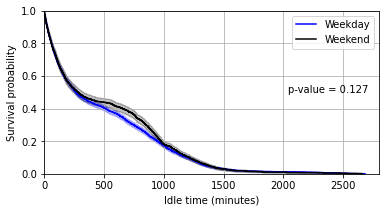

In [56]:
kmf_weekday = KaplanMeierFitter()
kmf_weekend = KaplanMeierFitter()

df_weekday = df[df['weekend'] == 0]
df_weekend = df[df['weekend'] == 1]

# Fit the data
kmf_weekday.fit(durations=df_weekday['life_time'],
              event_observed = df_weekday['event'], label="Weekday")
kmf_weekend.fit(durations=df_weekend['life_time'],
              event_observed = df_weekend['event'], label="Weekend")

# log rank test
results = logrank_test(df_weekday.life_time,
                       df_weekend.life_time,
                       event_observed_A = df_weekday.event,
                       event_observed_B = df_weekend.event)

## Plot
plt.figure(figsize=(6,3))
kmf_weekday.plot(color='blue')
kmf_weekend.plot(color='black')
plt.text(2040,0.5,'p-value = ' + str(format(results.p_value,'.3f')))
plt.xlabel("Idle time (minutes)")
plt.ylabel("Survival probability")
plt.grid()
plt.ylim([0,1])
plt.xlim([0,2800])
#plt.title("Survival graphs of weekday and weekend")
plt.savefig('../visualization/KM_curve_weekdayWeekend.pdf',bbox_inches='tight')
plt.show()

#### Weekdays

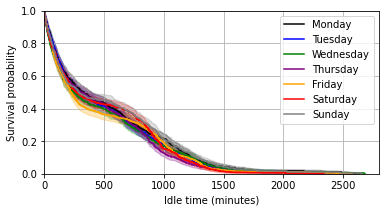

In [57]:
days = ['Monday','Tuesday','Wednesday','Thursday',
        'Friday','Saturday','Sunday']
colorD = ['black','blue','green','purple','orange','red','grey']

plt.figure(figsize=(6,3))
for i in range(len(days)):
    kmf = KaplanMeierFitter()
    
    df_temp = df[df['weekday_b_name'] == days[i]]
    
    # Fit the data
    kmf.fit(durations=df_temp['life_time'], event_observed=df_temp['event'],
            label = days[i])
    kmf.plot(color=colorD[i])
plt.xlabel("Idle time (minutes)")
plt.ylabel("Survival probability")
plt.ylim([0,1])
plt.xlim([0,2800])
plt.grid()
plt.savefig('../visualization/KM_curve_DOW.pdf',bbox_inches='tight')
plt.show()

#### TOD

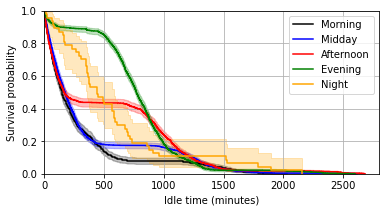

In [58]:
kmf_t1 = KaplanMeierFitter()
kmf_t2 = KaplanMeierFitter()
kmf_t3 = KaplanMeierFitter()
kmf_t4 = KaplanMeierFitter()
kmf_t5 = KaplanMeierFitter()


df_t1 = df[df['tod'] == 'Morning']
df_t2 = df[df['tod'] == 'Midday']
df_t3 = df[df['tod'] == 'Afternoon']
df_t4 = df[df['tod'] == 'Evening']
df_t5 = df[df['tod'] == 'Night']


# Fit the data
kmf_t1.fit(durations=df_t1['life_time'], event_observed=df_t1['event'],
           label = df_t1['tod'].unique()[0])
kmf_t2.fit(durations=df_t2['life_time'], event_observed=df_t2['event'],
           label = df_t2['tod'].unique()[0])
kmf_t3.fit(durations=df_t3['life_time'], event_observed=df_t3['event'],
           label = df_t3['tod'].unique()[0])
kmf_t4.fit(durations=df_t4['life_time'], event_observed=df_t4['event'],
           label = df_t4['tod'].unique()[0])
kmf_t5.fit(durations=df_t5['life_time'], event_observed=df_t5['event'],
           label = df_t5['tod'].unique()[0])

# ## Plot
plt.figure(figsize=(6,3))
kmf_t1.plot(color='black')
kmf_t2.plot(color='blue')
kmf_t3.plot(color='red')
kmf_t4.plot(color='green')
kmf_t5.plot(color='orange')
# plt.vlines(2*60,0,1)
# plt.vlines(8*60,0,1)
# plt.vlines(24*60,0,1)
plt.ylim([0,1])
plt.xlim([0,2800])
plt.grid()
plt.xlabel("Idle time (minutes)")
plt.ylabel("Survival probability")
plt.savefig('../visualization/KM_curve_tod.pdf',bbox_inches='tight')
plt.show()

#### Station Name

In [59]:
dictt = {'BOULDER / ALPINE ST1': 'ALPINE',
 'BOULDER / ATRIUM ST1': 'ATRIUM',
 'BOULDER / BASELINE ST1': 'BASELINE',
 'BOULDER / BOULDER PARK': 'BOULDER PARK',
 'BOULDER / EAST REC': 'EAST',
 'BOULDER / FACILITIES ST1': 'FACILITIES',
 'BOULDER / JUNCTION ST1': 'B. JUNCTION',
 'BOULDER / N BOULDER REC 1': 'N BOULDER',
 'BOULDER / REC CENTER': 'REC CENTER',
 'BOULDERJUNCTION / JUNCTION ST1': 'BJ. JUNCTION',
 'COMM VITALITY / 1000WALNUT': '1000 WALNUT',
 'COMM VITALITY / 1100WALNUT1': '1100 WALNUT',
 'COMM VITALITY / 1104 SPRUCE1': '1104 SPRUCE',
 'COMM VITALITY / 1400 WALNUT1': '1400 WALNUT',
 'COMM VITALITY / 1500PEARL': '1500 PEARL',
 'COMM VITALITY / 2200 BROADWAY1': '2200 BROADWAY',
 'COMM VITALITY / BOULDER JCTN': 'BOULDER JCTN'}

In [60]:
df = df[df['tod'] != 'Night']

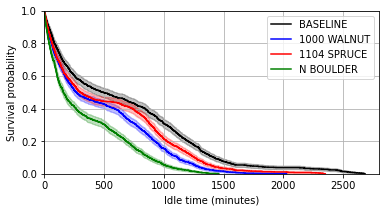

In [61]:
kmf_s1 = KaplanMeierFitter()
kmf_s2 = KaplanMeierFitter()
kmf_s3 = KaplanMeierFitter()
kmf_s4 = KaplanMeierFitter()

df_s1 = df[df['statN'] == 'BOULDER / BASELINE ST1']
df_s2 = df[df['statN'] == 'COMM VITALITY / 1000WALNUT']
df_s3 = df[df['statN'] == 'COMM VITALITY / 1104 SPRUCE1']
df_s4 = df[df['statN'] == 'BOULDER / N BOULDER REC 1']

# Fit the data
kmf_s1.fit(durations=df_s1['life_time'], event_observed=df_s1['event'],
           label = dictt[df_s1['statN'].unique()[0]])
kmf_s2.fit(durations=df_s2['life_time'], event_observed=df_s2['event'],
           label = dictt[df_s2['statN'].unique()[0]])
kmf_s3.fit(durations=df_s3['life_time'], event_observed=df_s3['event'],
           label = dictt[df_s3['statN'].unique()[0]])
kmf_s4.fit(durations=df_s4['life_time'], event_observed=df_s4['event'],
           label = dictt[df_s4['statN'].unique()[0]])

# ## Plot
plt.figure(figsize=(6,3))
kmf_s1.plot(color='black')
kmf_s2.plot(color='blue')
kmf_s3.plot(color='red')
kmf_s4.plot(color='green')
plt.grid()
plt.xlabel("Idle time (minutes)")
plt.ylabel("Survival probability")
plt.ylim([0,1])
plt.xlim([0,2800])
plt.savefig('../visualization/KM_curve_stations.pdf',bbox_inches='tight')
plt.show()

In [62]:
print("BASELINE:",kmf_s1.predict(60))
print("1000WALNUT:",kmf_s2.predict(60))
print("1104 SPRUCE1",kmf_s3.predict(60))
print("REC1:",kmf_s4.predict(60))

BASELINE: 0.8572695035460989
1000WALNUT: 0.8008626887131562
1104 SPRUCE1 0.8164915117219078
REC1: 0.7363367799113736


In [63]:
print("Mean vacancy time")
print("BASELINE:", round(np.mean(df_s1['life_time']),0))
print("1000WALNUT:",round(np.mean(df_s2['life_time']),0))
print("1104 SPRUCE1",round(np.mean(df_s3['life_time']),0))
print("REC1:",round(np.mean(df_s4['life_time']),0))

Mean vacancy time
BASELINE: 668.0
1000WALNUT: 476.0
1104 SPRUCE1 548.0
REC1: 333.0


In [64]:
print("Number of events")
print("BASELINE:", len(df_s1))
print("1000WALNUT:", len(df_s2))
print("1104 SPRUCE1",len(df_s3))
print("REC1:", len(df_s4))

Number of events
BASELINE: 1128
1000WALNUT: 1391
1104 SPRUCE1 1237
REC1: 1354


In [65]:
1128+1391+1237+1354

5110